This notebook runs within gammapy-1.1. (Only to have scipy and minuit imported, other gammapy functions are not used)

In [1]:
from scipy.stats import poisson
import numpy as np
import matplotlib.pyplot as plt
from  iminuit import Minuit
import sys
sys.path.append('../')
import colors as l 


In [2]:
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

### Energy Reconstruction
The energy reconstruction describes the probability to reconstruct the true energy value.
It is a Gaussian distributed around e_true with the energy resolution as the variance

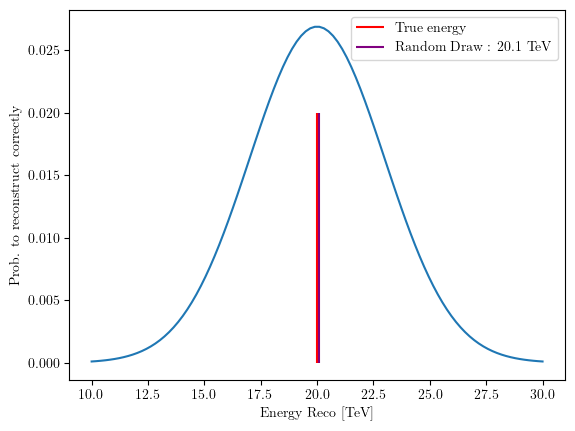

In [3]:
def energy_reco(e_reco, e_true, deltae):
    return  np.exp(-0.5 * ((e_reco - e_true) / deltae) ** 2)

e_true = 20
deltae = 3.
delta_comp =10
e_reco = np.linspace(e_true- delta_comp, e_true+delta_comp, 100)
energy_distribution = energy_reco(e_reco, e_true, deltae)
energy_distribution /= np.sum(energy_distribution)
plt.plot(e_reco, energy_distribution)
plt.vlines(e_true, 0., 0.02, label = "True energy", color = 'red')
plt.xlabel("Energy Reco [TeV]")
plt.ylabel("Prob. to reconstruct correctly ")

# random draw from this distribution:
energyreco = np.random.choice(e_reco, size=1, p= energy_distribution)[0]
plt.vlines(energyreco, 0., 0.02, label = f"Random Draw : {energyreco:.3} TeV", color = 'purple')
plt.legend()


### Count distribution

The counts are Poisson distributed. lambda is set to 40 TeV. And 1e3 samples are drawn. 

In [4]:
np.sqrt(40)

6.324555320336759

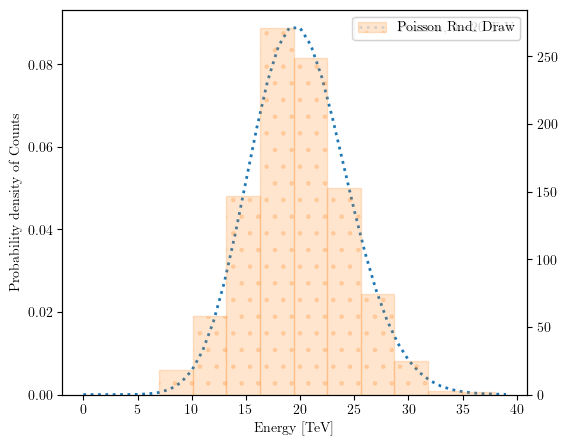

In [5]:
xmax = 40
mu_p = 20

#fig,ax = plt.subplots(1,1, figsize=(4, 3))
fig,ax = plt.subplots(1,1, figsize=(6, 5))

k_values = np.array(list(range(0, xmax)))
count_distr = [poisson.pmf(k, mu=mu_p) for k in k_values]
count_distr /= np.sum(count_distr)
ax.plot(k_values, count_distr , label = "Poisson, $\lambda$=20 TeV" , linestyle = ':',
        linewidth = 2,
       color = 'tab:blue')
plt.xlabel('Energy [TeV]')
plt.ylabel('Probability density of Counts')

ax2 = ax.twinx()
size = int(1e3)
samples_p = np.random.choice(k_values, size=size, p=count_distr)
c, bins, _ = ax2.hist(samples_p, density= False, label = "Poisson Rnd. Draw", alpha = 0.2, hatch = '.', 
                      edgecolor = 'tab:orange', color = 'tab:orange')
ax2.set_xlabel('Counts')

ax.set_ylim(0, ax.get_ylim()[1])
ax.legend()
ax2.legend()

### Apply the energy dispersion
For each of the drawn sample true energies the energy reconstruction is computed. Afterwards a reconstructed energy is drawn from this reconstruction probability. All reco energies are saved in ``samples``. 

28
34.36363636363636


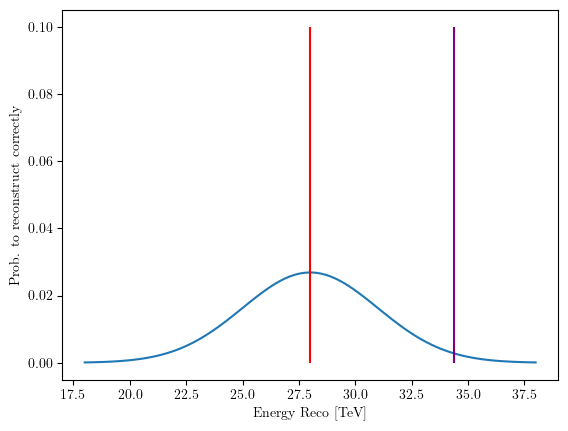

In [6]:
samples = []
for i, s in enumerate(samples_p):
    reco_values = np.linspace(s-delta_comp, s+delta_comp,100)
    energy_distribution = energy_reco(reco_values, s, deltae)
    energy_distribution /= np.sum(energy_distribution)
    rnd = np.random.choice(reco_values, size=1, p= energy_distribution)[0]
    if i<1:
        print(s)
        print(rnd)
        plt.figure()
        plt.plot(reco_values, energy_distribution)
        plt.vlines(s, 0., 0.1, label = "True energy", color = 'red')
        plt.xlabel("Energy Reco [TeV]")
        plt.ylabel("Prob. to reconstruct correctly ")
        plt.vlines(rnd, 0., 0.1, label = f"Random Draw : {rnd:.3} TeV", color = 'purple')
        plt.show()
        plt.close()
    samples.append(rnd)

In [7]:
def gaussian_2(x, mu, sigma, norm = 1):
    return norm * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# approximate the poisson distribution with a Gaussian, this is only to have a nicer plot. 
p_to_G = gaussian_2(k_values, mu = mu_p, sigma = np.sqrt(mu_p), norm = 1)
p_to_G /= np.sum(p_to_G)
# approximate the poisson distribution wiht systematic with a Gaussian with sigma = sqrt(lamda  + delta E**2)
# this is also just for plotting purposes
sys = gaussian_2(k_values, mu = mu_p, sigma = np.sqrt(mu_p + deltae**2), norm = 1)
sys /= np.sum(sys)

In [8]:
bbb = 10

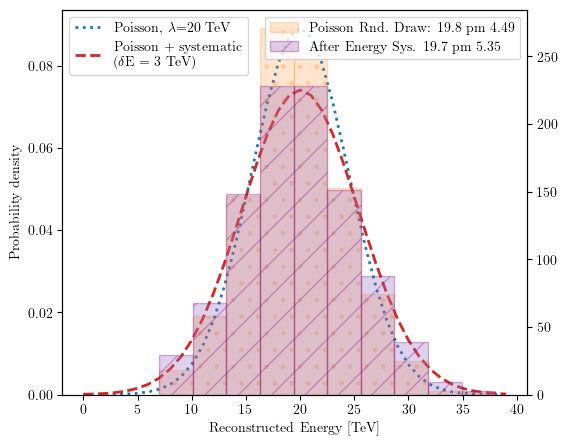

In [9]:
fig,ax = plt.subplots(1,1, figsize=(6, 5))
#ax.plot(k_values, count_distr , label = "Poisson" , linestyle = '-.')
plt.xlabel('Energy [TeV]')
plt.ylabel('Probability density of Counts')

ax.plot(k_values, p_to_G , label = "Poisson, $\lambda$=20 TeV" , linestyle = ':',
        linewidth = 2,
       color = 'tab:blue')

ax.plot(k_values, sys , label = "Poisson + systematic \n($\delta$E = 3 TeV)" , linestyle = '--',
        linewidth = 2,
       color = 'tab:red')
ax.set_ylim(0, ax.get_ylim()[1])
ax.legend(loc = 'upper left')
plt.xlabel('Reconstructed Energy [TeV]')
plt.ylabel('Probability density')

ax2 = ax.twinx()
size = int(1e3)
c, bins, _ = ax2.hist(samples_p, density= False,  bins = bbb, 
                      label = f"Poisson Rnd. Draw: {np.mean(samples_p):.3} pm {np.std(samples_p):.3}",
                      alpha = 0.2,
                      hatch = '.', edgecolor = 'tab:orange', color = 'tab:orange')

c, bins, _ = ax2.hist(samples, bins = bins, density= False,
                      label =f"After Energy Sys. {np.mean(samples):.3} pm {np.std(samples):.3}", alpha = 0.3, hatch = '/', 
                      edgecolor = 'purple',
                     color = 'tab:purple')


#ax2.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1])

ax2.legend()

## Maximum Liklelihood Estimator
To the ``samples`` distribution a Gaussian is fitted to find the center of the distribution ``E_c``. 

In [10]:
def gaussian(x, mu, sigma, norm = 1):
    return norm / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)


In [11]:
def Likelihood_cost( mu, sigma, norm):
    mu = gaussian(bin_center, mu, sigma, norm )
    L = np.sum(mu - c * np.log(mu))
    return L

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -3924                      │              Nfcn = 61               │
│ EDM = 4.96e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─────

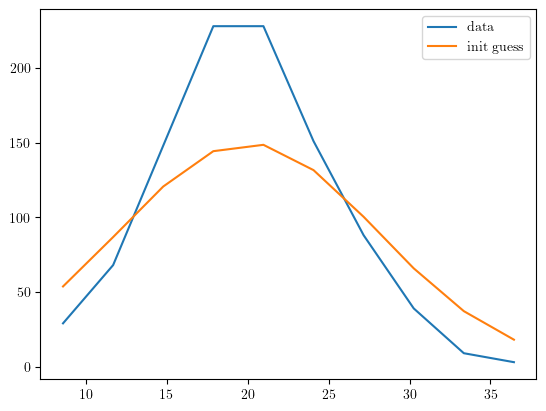

In [12]:
#Fitting:
mu_guess = 20
sigma_guess = 8
norm_guess = 3*size
bin_center = (bins[1:] + bins[:-1] )/2

plt.plot(bin_center, c, label = 'data')
plt.plot(bin_center,gaussian(x =bin_center, mu = mu_guess,
                            sigma = sigma_guess,
                            norm = norm_guess),
        label = 'init guess')
plt.legend()

minuit = Minuit(Likelihood_cost, mu = mu_guess, sigma = sigma_guess, norm = norm_guess)
m = minuit.migrad()
print(m)


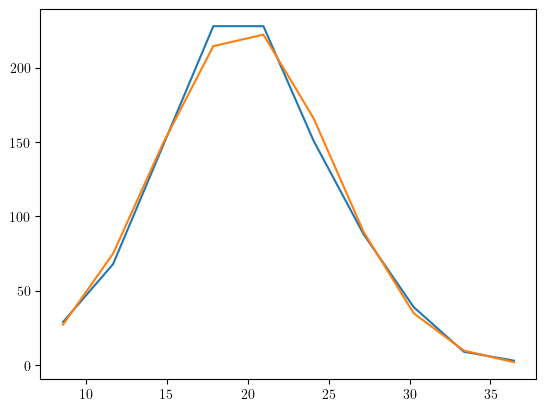

In [13]:
plt.plot(bin_center, c)
plt.plot(bin_center,gaussian(x =bin_center, mu = m.values[0],
                            sigma = m.values[1],
                            norm = m.values[2]))

In [14]:
# Print the estimated parameters and their uncertainties
print(f"The estimated parameters are: {m.values}")
print(f"The parameter uncertainties are: {m.errors}")

The estimated parameters are: <ValueView mu=19.735534795064677 sigma=5.425559470709119 norm=3099.888377862966>
The parameter uncertainties are: <ErrorView mu=0.2536466552059207 sigma=0.1970960837838888 norm=139.49517547608824>


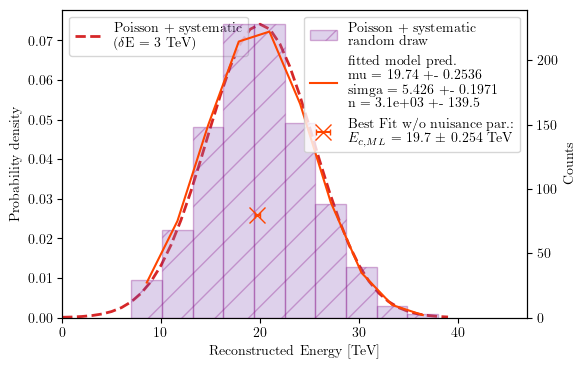

3.010703676168937


In [15]:


fig,ax = plt.subplots(1,1, figsize=(6, 4))
# prob. distribtutions:
ax.plot(k_values, sys , label = "Poisson + systematic \n($\delta$E = 3 TeV)" , linestyle = '--',
        linewidth = 2,
       color = 'tab:red')

ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlabel('Reconstructed Energy [TeV]')
ax.set_ylabel('Probability density')
ax.legend(loc = 'upper left')
ax.set_xlim(0,47)

# sample distributions:
ax2 = ax.twinx()
c, bins, _ = ax2.hist(samples, bins = bins, density= False,
                      label = "Poisson + systematic \n random draw", alpha = 0.3, hatch = '/', 
                      edgecolor = 'purple',
                     color = 'tab:purple')

# best-fit results:
label = "Best Fit w/o nuisance par.: \n $E_{c,ML}$ ="
ax2.errorbar(x = m.values[0], y = ax2.get_ylim()[1]/2-40, xerr =m.errors[0], fmt = 'x'  ,
               markersize= 11,capsize = 2,
             label =label +  f'  { m.values[0]:.3} $\pm$ {m.errors[0]:.3} TeV',
            color = 'orangered')
model_pred_fitted =  gaussian(bin_center, m.values[0], m.values[1], m.values[2])
ax2.plot(bin_center, model_pred_fitted, color = 'orangered',
        label = f"fitted model pred. \n mu =  { m.values[0]:.4} +- {m.errors[0]:.4} \n simga = {m.values[1]:.4} +- {m.errors[1]:.4} \nn = { m.values[2]:.4} +- {m.errors[2]:.4}")



ax2.set_ylabel("Counts")
ax2.legend(loc = 'upper right')
plt.show()
print(np.sqrt(m.errors[0]**2 + 3**2))


## Maximum A Posteriori Estimator

In [16]:
def prior(x):
    p =  (x-mu)**2 / sigma_sys**2
    return p
mu = 0
sigma_sys = deltae

In [17]:
def gaussian_model_nui(x, mu, sigma, norm, nui):
    return norm / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu -nui) / sigma) ** 2)


In [18]:
def posterior( mu, sigma, norm, nui):
    mu_ = gaussian_model_nui(bin_center, mu, sigma, norm, nui )
    L = np.sum(mu_ - c * np.log(mu_))
    P = prior(nui)
    return L + P

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -3924                      │              Nfcn = 103              │
│ EDM = 4.21e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─────

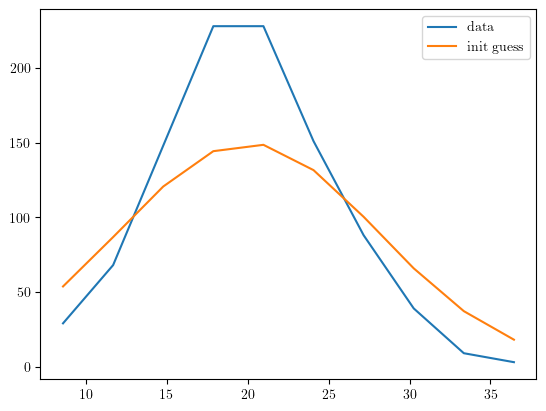

In [19]:
mu_guess_2 = 20
sigma_guess_2 = 8
norm_guess_2 = 3*size
nui_gues_2 = 0.0

plt.plot(bin_center, c, label = 'data')
plt.plot(bin_center,gaussian(x =bin_center, mu = mu_guess_2,
                            sigma = sigma_guess_2,
                            norm = norm_guess_2),
        label = 'init guess')
plt.legend()

minuit_prior = Minuit(posterior, mu = mu_guess_2, sigma = sigma_guess_2, norm =norm_guess_2, nui = nui_gues_2)
m_prior = minuit_prior.migrad()
print(m_prior)


In [20]:
# Print the estimated parameters and their uncertainties
print(f"The estimated parameters are: {m.values}")
print(f"The parameter uncertainties are: {m.errors}")

The estimated parameters are: <ValueView mu=19.735534795064677 sigma=5.425559470709119 norm=3099.888377862966>
The parameter uncertainties are: <ErrorView mu=0.2536466552059207 sigma=0.1970960837838888 norm=139.49517547608824>


In [21]:
# Print the estimated parameters and their uncertainties
print(f"The estimated parameters are: {m_prior.values}")
print(f"The parameter uncertainties are: {m_prior.errors}")

The estimated parameters are: <ValueView mu=19.728136253397704 sigma=5.426577328999429 norm=3100.012399707946 nui=0.006011749362030416>
The parameter uncertainties are: <ErrorView mu=3.010720801585861 sigma=0.19721962595942796 norm=139.50273311972097 nui=3.0000017015606555>


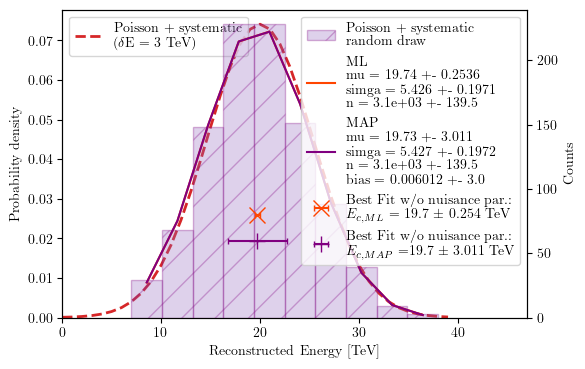

3.010703676168937


In [22]:


fig,ax = plt.subplots(1,1, figsize=(6, 4))
# prob. distribtutions:
ax.plot(k_values, sys , label = "Poisson + systematic \n($\delta$E = 3 TeV)" , linestyle = '--',
        linewidth = 2,
       color = 'tab:red')

ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlabel('Reconstructed Energy [TeV]')
ax.set_ylabel('Probability density')
ax.legend(loc = 'upper left')
ax.set_xlim(0,47)

# sample distributions:
ax2 = ax.twinx()
c, bins, _ = ax2.hist(samples, bins = bins, density= False,
                      label = "Poisson + systematic \n random draw", alpha = 0.3, hatch = '/', 
                      edgecolor = 'purple',
                     color = 'tab:purple')

# best-fit results:
label = "Best Fit w/o nuisance par.: \n $E_{c,ML}$ ="
ax2.errorbar(x = m.values[0], y = ax2.get_ylim()[1]/2-40, xerr =m.errors[0], fmt = 'x'  ,
               markersize= 11,capsize = 2,
             label =label +  f'  { m.values[0]:.3} $\pm$ {m.errors[0]:.3} TeV',
            color = 'orangered')
model_pred_fitted =  gaussian(bin_center, m.values[0], m.values[1], m.values[2])
ax2.plot(bin_center, model_pred_fitted, color = 'orangered',
        label = f"ML\n mu =  { m.values[0]:.4} +- {m.errors[0]:.4} \n simga = {m.values[1]:.4} +- {m.errors[1]:.4} \nn = { m.values[2]:.4} +- {m.errors[2]:.4}")


label = "Best Fit w/o nuisance par.: \n $E_{c,MAP}$ ="
ax2.errorbar(x = m_prior.values[0], y = ax2.get_ylim()[1]/2-60, xerr =m_prior.errors[0], fmt = '+' ,
             markersize= 11,capsize = 2,
           label= label +  f"{ m_prior.values[0]:.3} $\pm$ {m_prior.errors[0]:.4} TeV ", 
             color = 'Purple')
model_pred_fitted =  gaussian(bin_center, m_prior.values[0], m_prior.values[1], m_prior.values[2])
ax2.plot(bin_center, model_pred_fitted, color = 'Purple',
        label = f"MAP \n mu =  { m_prior.values[0]:.4} +- {m_prior.errors[0]:.4} \n simga = {m_prior.values[1]:.4} +- {m_prior.errors[1]:.4} \nn = { m_prior.values[2]:.4} +- {m_prior.errors[2]:.4}  \nbias = { m_prior.values[3]:.4} +- {m_prior.errors[3]:.4}")


ax2.set_ylabel("Counts")
ax2.legend(loc = 'upper right')
plt.show()
print(np.sqrt(m.errors[0]**2 + 3**2))


## Final Plot

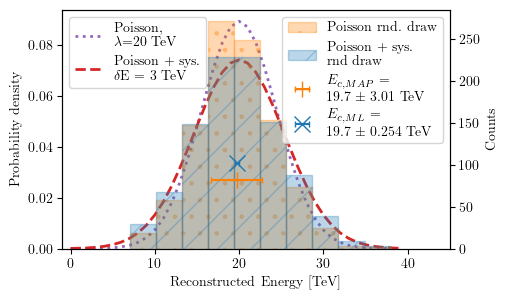

3.010703676168937


In [23]:
def final_plot(plot_scan = False):
    if plot_scan:
        fig,(ax , ax3) = plt.subplots(2,1, figsize=(5, 6.1))
    else:
        fig,ax = plt.subplots(1,1, figsize=(5, 3.1))
        
    # prob. distribtutions:
    ax.plot(k_values, p_to_G , label = "Poisson, \n$\lambda$=20 TeV" , linestyle = ':',
            linewidth = 2,
           color = 'tab:purple')

    ax.plot(k_values, sys , label = "Poisson + sys. \n$\delta$E = 3 TeV" , linestyle = '--',
            linewidth = 2,
           color = 'tab:red')

    ax.set_ylim(0, ax.get_ylim()[1])
    ax.set_xlabel('Reconstructed Energy [TeV]')
    ax.set_ylabel('Probability density')
    ax.legend(loc = 'upper left')
    ax.set_xlim(-1,45)

    # sample distributions:
    ax2 = ax.twinx()
    c, bins_, _ = ax2.hist(samples_p, density= False, bins =bbb,
                          label = "Poisson rnd. draw", alpha = 0.3, hatch = '.', edgecolor = l.orange,
                         color = l.orange)
    c, bins_, _ = ax2.hist(samples, bins = bins_, density= False,
                          label = "Poisson + sys. \n rnd draw", alpha = 0.3, hatch = '/', 
                          edgecolor = l.blue,
                         color = l.blue)

    
    label = "Best Fit w/o nui. par.: \n $E_{c,MAP}$ ="
    label = "$E_{c,MAP}$ ="

    ax2.errorbar(x = m_prior.values[0], y = ax2.get_ylim()[1]/2-60, xerr =m_prior.errors[0], fmt = '+' ,
                 markersize= 11,capsize = 2,
               label= label +  f"\n{ m_prior.values[0]:.3} $\pm$ {m_prior.errors[0]:.3} TeV ", 
                 color = l.orange)
    
    # best-fit results:
    label = "Best Fit w/o nui. par.: \n $E_{c,ML}$ ="
    label = " $E_{c,ML}$ ="

    ax2.errorbar(x = m.values[0], y = ax2.get_ylim()[1]/2-40, xerr =m.errors[0], fmt = 'x'  ,
                   markersize= 11,capsize = 2,
                 label =label +  f'\n  { m.values[0]:.3} $\pm$ {m.errors[0]:.3} TeV',
                color = l.blue)
 

    ax2.set_ylabel("Counts")
    ax2.legend(loc = 'upper right')
    plt.show()
    print(np.sqrt(m.errors[0]**2 + 3**2))
   

    
    return fig, ax


fig, ax = final_plot(plot_scan = False)
fig.savefig("prob_best_fit.pdf", bbox_inches='tight')

In [24]:
data, bins = np.histogram(samples, bins = bbb)
data_dens, bins_dens = np.histogram(samples, bins = bbb, density=True)

factor = np.max(data) / np.max(data_dens)
factor

3667.6767676767668

3.010703676168937


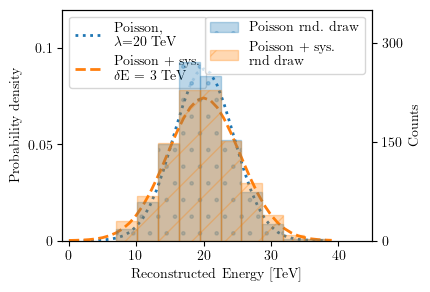

In [25]:
def final_plot2(plot_scan = False):
    fig,ax = plt.subplots(1,1, figsize=(4,3))
        
    # prob. distribtutions:
    ax.plot(k_values, p_to_G , label = "Poisson, \n$\lambda$=20 TeV" , linestyle = ':',
            linewidth = 2,
           color = 'tab:blue')

    ax.plot(k_values, sys , label = "Poisson + sys. \n$\delta$E = 3 TeV" , linestyle = '--',
            linewidth = 2,
           color = 'tab:orange')

    ax.set_ylim(0, ax.get_ylim()[1])
    ax.set_xlabel('Reconstructed Energy [TeV]')
    ax.set_ylabel('Probability density')
    ax.legend(loc = 'upper left')
    ax.set_xlim(-1,45)

    # sample distributions:
    ax2 = ax.twinx()
    c, bins_, _ = ax2.hist(samples_p, density= False, bins =bbb,
                          label = "Poisson rnd. draw", alpha = 0.3, hatch = '.', edgecolor = l.blue,
                         color = l.blue)
    c, bins_, _ = ax2.hist(samples, bins = bins_, density= False,
                          label = "Poisson + sys. \n rnd draw", alpha = 0.3, hatch = '/', 
                          edgecolor = l.orange,
                         color = l.orange)

   
    ax2.set_ylim(0,350)
    ax.set_ylim(0,0.12)
    #ax2.set_ylim(0, ax.get_ylim()[1] *    factor)

    ax2.set_ylabel("Counts")
    ax2.legend(loc = 'upper right')
    print(np.sqrt(m.errors[0]**2 + 3**2))
    ax.set_yticks([0,0.05, 0.1], [0, 0.05, 0.1])
    ax2.set_yticks([0,150, 300], [0,150,  300])
    plt.show()
    
    return fig, ax


fig, ax = final_plot2(plot_scan = False)

fig.savefig("prob_best_fit.pdf", bbox_inches='tight')
fig.savefig("prob_best_fit.png", bbox_inches='tight',  dpi=300)

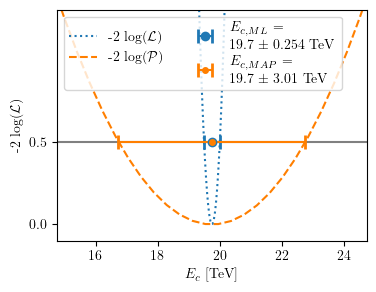

In [26]:
fig,ax = plt.subplots(1,1, figsize=(4,3))

p = 'mu'
x, y ,suc= m.mnprofile(p)
y = y * 0.5
ax.plot(x, y- np.min(y), color = l.blue,linestyle = 'dotted', label = "-2 log($\mathcal{L}$)");

x, y ,suc= m_prior.mnprofile(p)
y = y * 0.5

ax.plot(x, y- np.min(y), color = l.orange, linestyle = 'dashed', label = "-2 log($\mathcal{P}$)");

ax.hlines(0.5, ax.get_xlim()[0], ax.get_xlim()[1], color = 'grey');
label = "$E_{c,ML}$ ="
ax.errorbar(x = m.values[0], y = 0.5, xerr =m.errors[0], fmt = 'o'  ,
               markersize= 5,capsize = 5,markeredgewidth = 2,
             label =label +  f"\n{ m.values[0]:.3} $\pm$ {m.errors[0]:.3} TeV ", 
            color = l.blue, )
label = "$E_{c,MAP}$ ="
ax.errorbar(x = m_prior.values[0], y = 0.5, xerr =m_prior.errors[0], fmt = 'o' , 
                 markersize= 3,capsize = 5, markeredgewidth = 2,
               label= label +  f"\n{ m_prior.values[0]:.3} $\pm$ {m_prior.errors[0]:.3} TeV ", 
                 color = l.orange)
ax.set_xlabel('$E_c$ [TeV]')
delta = 5
ax.set_xlim(m_prior.values[0] - delta, m_prior.values[0] + delta)
ax.set_ylim(-0.1, 1.3)
ax.set_ylabel("-2 log($\mathcal{L}$)")
ax.legend(ncol = 2)
ax.set_yticks([0, 0.5], [0., 0.5])
fig.savefig("scsan.pdf", bbox_inches='tight')

In [27]:
def prior2(x):
    p =  (x-mu)**2 / sigma_sys**2
    return p
mu = 0
sigma_sys = deltae

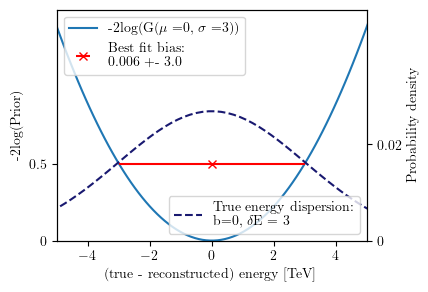

In [32]:
fig,ax = plt.subplots(1,1, figsize = (4,3))
nui_values = np.linspace(-sigma_sys*2, sigma_sys*2, 100)

ax.plot(nui_values, prior2(nui_values) * 0.5, label = "-2log(G($\mu$ =0, $\sigma$ =3))")
ax.set_xlabel("Energy resolution nuisance parameter Value [TeV]")
ax.set_xlabel("(true - reconstructed) energy [TeV]")

ax.set_ylabel("-2log(Prior)")
e_true = 0.
e_reco = np.linspace(e_true- delta_comp, e_true+delta_comp, 100)
energy_distribution = energy_reco(e_reco, e_true, deltae)
energy_distribution /=np.sum(energy_distribution)
ax.set_ylim(0, ax.get_ylim()[1])

#energy_distribution /= np.sum(energy_distribution)
plot_dist = 1
if plot_dist:
    ax2 =plt.twinx()

    ax2.plot(e_reco, energy_distribution, label = "True energy dispersion:\n b=0, $\delta$E = 3", 
             color = 'midnightblue', linestyle = '--')
    ax2.set_ylim(0, ax2.get_ylim()[1]*2.3)
    ax2.set_ylabel("Probability density")
    ax2.legend(loc = 'lower right')
    ax2.set_ylim(0,0.048)
    
ax.errorbar(x = m_prior.values[3], y = 0.5, fmt = 'x' ,xerr = 3,# m_prior.errors[3], 
           label= f"Best fit bias:\n { m_prior.values[3]:.1} +- {m_prior.errors[3]:.6} ", color = 'red')
ax.legend(loc = 'upper left')
ax.set_xlim(-5,5)
ax.set_ylim(0,1.5)
ax.set_yticks([0, 0.5], [0, 0.5])
ax2.set_yticks([0, 0.02,], [0, 0.02])


fig.savefig("prior.pdf", bbox_inches='tight')


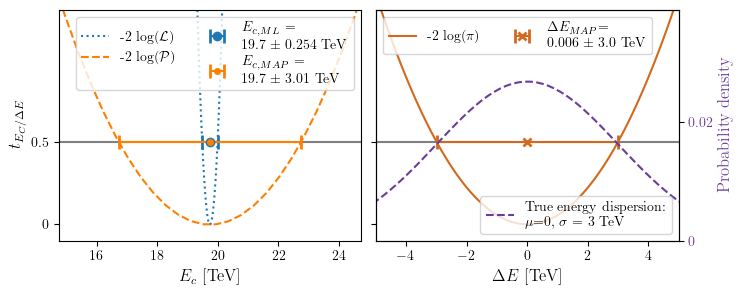

In [62]:
fig,(ax, ax1) = plt.subplots(1,2, figsize=(8,3), sharey = True)

p = 'mu'
x, y ,suc= m.mnprofile(p)
y = y * 0.5
ax.plot(x, y- np.min(y), color = l.blue,linestyle = 'dotted', label = "-2 log($\mathcal{L}$)");

x, y ,suc= m_prior.mnprofile(p)
y = y * 0.5

ax.plot(x, y- np.min(y), color = l.orange, linestyle = 'dashed', label = "-2 log($\mathcal{P}$)");

ax.hlines(0.5, ax.get_xlim()[0], ax.get_xlim()[1], color = 'grey');
label = "$E_{c,ML}$ ="
ax.errorbar(x = m.values[0], y = 0.5, xerr =m.errors[0], fmt = 'o'  ,
               markersize= 5,capsize = 5,markeredgewidth = 2,
             label =label +  f"\n{ m.values[0]:.3} $\pm$ {m.errors[0]:.3} TeV ", 
            color = l.blue, )
label = "$E_{c,MAP}$ ="
ax.errorbar(x = m_prior.values[0], y = 0.5, xerr =m_prior.errors[0], fmt = 'o' , 
                 markersize= 3,capsize = 5, markeredgewidth = 2,
               label= label +  f"\n{ m_prior.values[0]:.3} $\pm$ {m_prior.errors[0]:.3} TeV ", 
                 color = l.orange)
ax.set_xlabel('$E_c$ [TeV]', fontsize = 12)
delta = 5
ax.set_xlim(m_prior.values[0] - delta, m_prior.values[0] + delta)
ax.set_ylim(-0.1, 1.3)
ax.set_ylabel("-2 log($\mathcal{L}$)", fontsize = 12)
ax.set_ylabel("$t_{E_C / \Delta E}$", fontsize = 12)

ax.legend(ncol = 2)
ax.set_yticks([0, 0.5], [0, 0.5])


############
ax = ax1
nui_values = np.linspace(-sigma_sys*2, sigma_sys*2, 100)

ax.plot(nui_values, prior2(nui_values) * 0.5, label = "-2 log($\pi$)",
       color = l.dorange) 
ax.set_xlabel("$\Delta E$ [TeV]", fontsize = 12)

#ax.set_ylabel("-2log(Prior)", fontsize = 12)
e_true = 0.
e_reco = np.linspace(e_true- delta_comp, e_true+delta_comp, 100)
energy_distribution = energy_reco(e_reco, e_true, deltae)
energy_distribution /=np.sum(energy_distribution)
ax.set_ylim(0, ax.get_ylim()[1])

#energy_distribution /= np.sum(energy_distribution)
plot_dist = 1
if plot_dist:
    ax2 =plt.twinx()

    ax2.plot(e_reco, energy_distribution, label = "True energy dispersion:\n $\mu$=0, $\sigma$ = 3 TeV", 
             color = l.purple, linestyle = '--')
    ax2.set_ylim(0, ax2.get_ylim()[1]*2.3)
    ax2.set_ylabel("Probability density", fontsize = 12, color = l.purple)
    ax2.legend(loc = 'lower right')
    ax2.set_ylim(0,0.039)
ax.hlines(0.5, ax.get_xlim()[0], ax.get_xlim()[1], color = 'grey');

bias_name = "$\Delta E_{MAP}$"
ax.errorbar(x = m_prior.values[3], y = 0.5, fmt = 'x' ,xerr =  m_prior.errors[3], capsize = 5,markeredgewidth =2,
           label= bias_name +f"=\n { m_prior.values[3]:.1} $\pm$ {m_prior.errors[3]:.4} TeV", color = l.dorange)
ax.legend(loc = 'upper left', ncol=2)
ax.set_xlim(-5,5)
#ax.set_ylim(0,1.5)
ax.set_ylim(-0.1, 1.3)

ax.set_yticks([0, 0.5], [0, 0.5])
ax2.set_yticks([0, 0.02,], [0, 0.02], color = l.purple)


plt.subplots_adjust(wspace=0.05, hspace=0)
fig.savefig("joint.pdf", bbox_inches='tight')

## Likelihood Scan

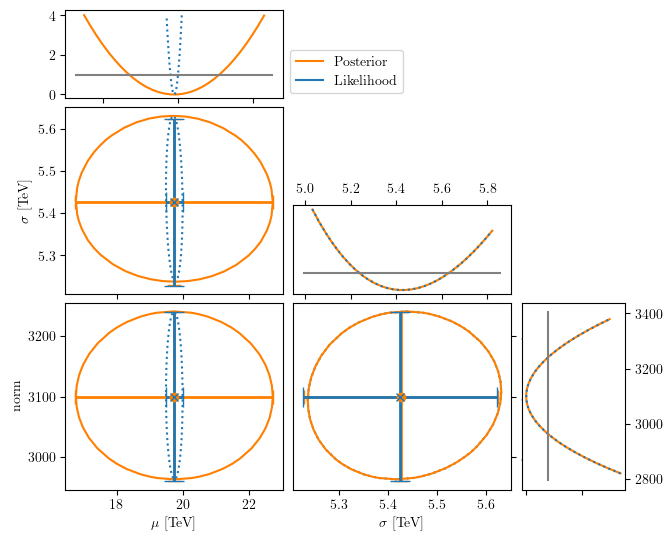

In [30]:
fig3 = plt.figure( figsize = (7,6))
gs = fig3.add_gridspec(5, 5)
ax_a = fig3.add_subplot(gs[0, 0:2])
axs_2 = fig3.add_subplot(gs[1:3, 0:2])
axs_1 = fig3.add_subplot(gs[3:5, 0:2])

ax_c = fig3.add_subplot(gs[2:3,  2:4])
axs_3 = fig3.add_subplot(gs[3:5,  2:4])
ax_b = fig3.add_subplot(gs[3:5,  4:5])


parameters = [['mu', 'norm'],['mu', 'sigma'], ['sigma', 'norm']]
axs = [axs_1, axs_2, axs_3]
colors = [l.blue, l.orange]
for i,p in enumerate(parameters):
    for cl in [0.39]:
        pts = m.mncontour(p[0], p[1], cl=cl, size=50)
        x, y = np.transpose(pts)
        axs[i].plot(x, y, color = colors[0], linestyle= 'dotted');    
        pts = m_prior.mncontour(p[0], p[1], cl=cl, size=50,
                               )
        x, y = np.transpose(pts)
        axs[i].plot(x, y, "-", color = colors[1]);
    axs[i].errorbar(minuit_prior.params[p[0]].value,
                   minuit_prior.params[p[1]].value,
                    xerr = minuit_prior.errors[p[0]],
                   yerr = minuit_prior.errors[p[1]],
                   fmt = 'o',
                   capsize = 5,
                   linewidth = 2,
                   color = colors[1])
    
    axs[i].errorbar(minuit.params[p[0]].value,
                   minuit.params[p[1]].value,
                    xerr = minuit.errors[p[0]],
                   yerr = minuit.errors[p[1]],
                   fmt = 'x',
                   capsize = 7,
                   linewidth = 2,
                   color = colors[0])
axs_1.set_ylabel("norm")
axs_1.set_xlabel("$\mu$ [TeV]")
axs_2.set_ylabel("$\sigma$ [TeV]")
axs_3.set_xlabel("$\sigma$ [TeV]")


axs = [ax_a, ax_b, ax_c]
for i, p in enumerate(['mu', 'norm', 'sigma']):
    if i ==1:
        x, y ,suc= m_prior.mnprofile(p)
        axs[i].plot(y- np.min(y),x, color = l.orange);
        x, y ,suc= m.mnprofile(p)
        axs[i].plot(y- np.min(y),x, color = l.blue, linestyle = 'dotted');
        
        axs[i].vlines(1, axs[i].get_ylim()[0], axs[i].get_ylim()[1], color = 'grey');
        
    else:
        x, y ,suc= m_prior.mnprofile(p)
        axs[i].plot(x, y- np.min(y), color = l.orange);
        x, y ,suc= m.mnprofile(p)
        axs[i].plot(x, y- np.min(y), color = l.blue,linestyle = 'dotted');
        
        axs[i].hlines(1, axs[i].get_xlim()[0], axs[i].get_xlim()[1], color = 'grey');
        
ax_a.plot(np.nan, np.nan, color = l.orange, label = "Posterior")
ax_a.plot(np.nan, np.nan, color = l.blue, label = "Likelihood")    
ax_a.legend(loc='center left', bbox_to_anchor=(1.0, 0.3))

ax_a.xaxis.set_label_position("top")

ax_b.yaxis.set_label_position("right")
ax_b.yaxis.tick_right()
ax_b.tick_params(left = 0, labelleft  = 0,  right = 1,  labelright=1, bottom=1, labelbottom=False)

ax_c.tick_params(left = 0, labelleft  = 0,  top = 1,  labeltop=1, bottom=1, labelbottom=False)
ax_c.xaxis.set_label_position("top")

axs_2.set_xlabel("")
axs_2.tick_params(top = 0, labeltop  = 0, )
axs_3.yaxis.set_label_position("right")
axs_3.yaxis.tick_right()

plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.1, 
                        hspace=0.1)
fig3.savefig('matrix.pdf')


In [31]:
sdf

NameError: name 'sdf' is not defined

## Vary delta

In [ ]:
deltae

In [ ]:
mu_guess_2 = 20
sigma_guess_2 = 8
norm_guess_2 = 3000
nui_gues_2 = 0.0

mu = 0
m_priors = []
sigma_syss  =  [2,3, 4]
for sigma_sys in sigma_syss:
    minuit_prior = Minuit(posterior, mu = mu_guess_2, sigma = sigma_guess_2, norm =norm_guess_2, nui = nui_gues_2)
    m_prior_ = minuit_prior.migrad()
    print(m_prior_)
    m_priors.append(m_prior_)


sigma_sys = 3.0

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(5, 3.1))

p = 'mu'
x, y ,suc= m.mnprofile(p)
ax.plot(x, y- np.min(y), color = l.blue,linestyle = 'dotted', label = "-2 log(L) scan");

ax.hlines(1, 0, 100, color = 'grey');

colors= [l.red, l.orange, l.brown]
delta = [-0.1, 0.,0.1]
for  i,m_ in  enumerate(m_priors):
    sigma_sys = sigma_syss[i]
    x, y ,suc= m_.mnprofile(p)
    ax.plot(x, y- np.min(y), linestyle = 'dashed', label = f"-2 log(P), $\sigma$ = {sigma_sys}", color = colors[i]);
    ax.fill_between (  [ m_.values[0] - m_.errors[0], m_.values[0] + m_.errors[0]] , 0, 4,  color = colors[i],
                    alpha = 0.2)
    label = " $E_{c,ML}$ ="
    ax.errorbar(x = m_.values[0], y = 1.+ delta[i], xerr =m_.errors[0], fmt = '+' ,
                 markersize= 11,capsize = 4, color = colors[i],
               label= label +  f"\n{ m_.values[0]:.3} $\pm$ {m_.errors[0]:.3} TeV ", 
                 )

ax.errorbar(x = m.values[0], y =  + 1.2, xerr =m.errors[0], fmt = 'x'  ,
               markersize= 11,capsize = 3,
             label ='',
            color = l.blue, )


ax.set_xlabel('Reconstructed Energy [TeV]')
delta = 6
ax.set_xlim(m_prior.values[0] - delta, m_prior.values[0] + delta)
ax.set_ylabel("-2 log(L)")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# fig.savefig("scsan.png", bbox_inches='tight')
# fig.savefig("scsan.svg", bbox_inches='tight')
# fig.savefig("scsan.pdf", bbox_inches='tight')